# Deep Deterministic Polity Gradient - Cartpole

DDPG is an off-policy method and is a modified version of Q-learning. The loss function is:

$$ L = Q_\phi(s_t, a_t) - (r_t + \gamma (1-d_t) Q_\phi (s_{t+1}, \mu_\theta(s_{t+1}))) $$

This is also based on Actor-Critic method with separated policy (paramirized by $\theta$) and Q value evaluation (paramirized by $\phi$).

In the DQN implementation, we used the same network to update the Q values and to compute the target value. This configuration is unstable since the target is an implicated in the updating process which cahnges continuously. Thus the network is chasing a moving target, which can unstablize the training.

So overcome this, it introduced sepatated parameters $\theta'$ and $\phi'$ for target:

$$ L = Q_\phi(s_t, a_t) - (r_t + \gamma (1-d_t) Q_{\phi'} (s_{t+1}, \mu_{\theta'}(s_{t+1}))) $$

and they are updated as:

$$ \begin{cases}  \phi' = \tau \phi + (1-\tau) \phi'\\
  \theta' = \tau \theta + (1-\tau) \theta' \end{cases} $$

where $\tau$ is a small value for update.



In [10]:
import torch, random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import HTML
from cartpole_utils import env_cartpole, display_frames_as_gif, goalAchieved, test_cartpole

In [11]:
# networks

# Q value net
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, action_dim)

    def forward(self, state, action):
        out = torch.cat((state, action), dim=-1)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)
    
# policy net
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, action_dim)

    def forward(self, state):
        out = torch.relu(self.fc1(state))
        logits = self.fc2(out)
        return torch.tanh(logits)

In [12]:
class ReplayMemory:
    def __init__(self, size):
        self.games = []
        self.size = size

    def add(self, attrib:list):
        if len(self) == self.size:
            self.games.pop(0)  # Remove the oldest sample if the memory is full.
        self.games.append(attrib)
        
    def __len__(self):
        return len(self.games)
    
    def clear(self):
        self.games.clear()
    
    def sample(self, batch_size):
        out = []
        samples = random.sample(self.games, batch_size)
        for i in range(len(samples[0])):
            tensor = torch.tensor([items[i] for items in samples])
            out.append(tensor)
        return out

In [13]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [15]:
class DDPMAgent:
    def __init__(self):
        self.qvalues = QNet(5, 1)
        self.qtargets = QNet(5, 1).requires_grad_(False)
        self.pvalues = PolicyNet(4, 1)
        self.ptargets = PolicyNet(4, 1).requires_grad_(False)
        self.action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)
        self.opt_qvalues = torch.optim.AdamW(self.qvalues.parameters(), lr=0.0005)
        self.opt_policy = torch.optim.AdamW(self.pvalues.parameters(), lr=0.0005)

        self.epsilon = 1.0 #exploration rate
        self.epsilon_decay = 1.0/(1000*80)
        self.epsilon_final = 0.1

    def act(self, state, train=True):
        if np.random.random() < self.epsilon and train:
            action = random.choice([0,1])
            return action
        if isinstance(state, np.ndarray):
            if len(state.shape) == 1:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            else:
                state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            noise = self.action_noise()
            with torch.no_grad():
                action = self.pvalues(state).squeeze(-1).numpy()
            action = np.clip(action, 0., 1.)
        return float(action.item())
    
    def update_epsilon(self):
        self.epsilon -= self.epsilon_decay
        if self.epsilon < self.epsilon_final:
            self.epsilon = self.epsilon_final
    
    def learn(self, plays, batch_size):
        gamma = 0.99

        # get data
        samples = plays.sample(batch_size)
        for sample in samples:
            if len(sample.shape) == 1:
                sample.unsqueeze_(-1)
        
        # get samples batch
        states, rewards, actions, states_next, dones = samples

        # critic
        q_values = self.qvalues(states, actions)
        with torch.no_grad():
            theta_target = self.ptargets(states_next)

            q_next = self.qtargets(states_next, theta_target)

            q_targets = rewards + (1.0 - dones) * gamma * q_next

        q_loss = F.mse_loss(q_values, q_targets, reduction='mean')

        self.opt_qvalues.zero_grad()
        q_loss.backward()
        self.opt_qvalues.step()

        # actor
        theta = self.pvalues(states)
        self.qvalues.requires_grad_(False)
        q_target_max = self.qvalues(states, theta)

        policy_loss = -q_target_max.mean()

        self.opt_policy.zero_grad()
        policy_loss.backward()
        self.opt_policy.step()

        self.qvalues.requires_grad_(True)
        
        # update target networks
        self.update_target()
        self.update_epsilon()

        return q_loss.detach().item(), policy_loss.detach().item()
    
    def update_target(self):
        tau = 0.01
        for target, source in zip(self.qtargets.parameters(), self.qvalues.parameters()):
            target.data.copy_(tau * source.data + (1.0 - tau) * target.data)

        for target, source in zip(self.ptargets.parameters(), self.pvalues.parameters()):
            target.data.copy_(tau * source.data + (1.0 - tau) * target.data)

In [16]:
# train loop

epochs = 2000
batch_size = 250
state_num = 4 # 
action_num = 2
memory = ReplayMemory(1000)
agent = DDPMAgent()

scores = []
losses = []

for e in range(epochs):
    # reset environment
    state, _ = env_cartpole.reset()

    currState = state
    done = False

    score = 0
    tot_loss = [0., 0.]
    count = 0

    # run an episode
    while not done :
        
        # choose action
        action = int(agent.act(state))

        # take action on env
        state, reward, done, trunc, _ = env_cartpole.step(action)
        
        # add to replay memory
        memory.add([currState, reward, action, state, (1.0 if done else 0.0)])

        if len(memory) >= batch_size:
            # train the network
            qloss, ploss = agent.learn(memory, batch_size)
            tot_loss[0] += qloss
            tot_loss[1] += ploss
            count += 1

        currState = state.copy()
        # update score
        score += 1

        if score > 800:
            break
    
    scores = np.append(scores, score)
    tmp = [l/count if count > 0 else 0. for l in tot_loss]
    losses = np.append(losses, tmp)


    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, qloss: {tot_loss[0]/count:.4f}, ploss: {tot_loss[1]/count:.4f}, epsilon: {agent.epsilon:.4f}")
    if goalAchieved(scores):
        break

epoche: 100, score: 16, qloss: 1.6675, ploss: -13.8241, epsilon: 0.9765
epoche: 200, score: 12, qloss: 7.5092, ploss: -38.6616, epsilon: 0.9454
epoche: 300, score: 12, qloss: 30.0134, ploss: -70.3918, epsilon: 0.9137
epoche: 400, score: 26, qloss: 74.0446, ploss: -95.5511, epsilon: 0.8806
epoche: 500, score: 17, qloss: 133.7024, ploss: -127.0658, epsilon: 0.8443
epoche: 600, score: 34, qloss: 124.0312, ploss: -153.6142, epsilon: 0.8023
epoche: 700, score: 98, qloss: 77.7481, ploss: -181.9482, epsilon: 0.7529
epoche: 800, score: 17, qloss: 189.1569, ploss: -197.4646, epsilon: 0.6927
epoche: 900, score: 137, qloss: 70.3350, ploss: -194.5342, epsilon: 0.6084
epoche: 1000, score: 197, qloss: 24.9315, ploss: -256.7336, epsilon: 0.4515
epoche: 1100, score: 204, qloss: 4.0504, ploss: -234.6880, epsilon: 0.1000
epoche: 1200, score: 269, qloss: 1.0485, ploss: -167.4158, epsilon: 0.1000


In [17]:
frames = test_cartpole(env_cartpole, 300, agent=agent)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

301


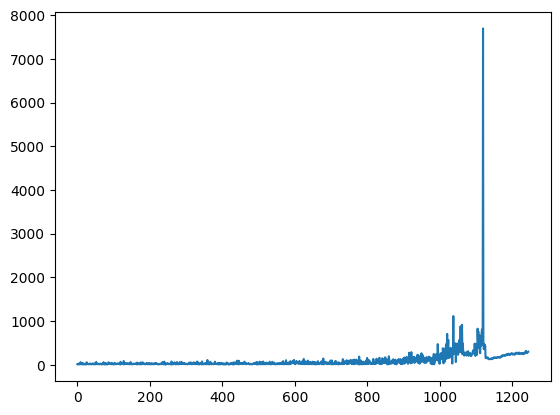

In [18]:
plt.plot(scores)

# Clipped Double-Q Learning (Twin-Q)

We can use 2 target value networks and they are updated at each epoch using:

$$ L = Q_\phi(s_t, a_t) - (r_t + \gamma (1-d_t) min [Q_{\phi'_i} (s_{t+1}, \mu_\theta(s_{t+1}))])$$

and we update the targets as:

$$ 
\begin{cases}  
    \phi'_1 = \tau \phi_1 + (1-\tau) \phi'_1 \\
    \phi'_2 = \tau \phi_2 + (1-\tau) \phi'_2 \\
    \theta' = \tau \theta + (1-\tau) \theta' 
\end{cases}
$$

In [96]:
class DoubleQAgent:
    def __init__(self):
        self.qvalues1 = QNet(5, 1)
        self.qvalues2 = QNet(5, 1)
        self.pvalues = PolicyNet(4, 1)
        self.qtargets1 = QNet(5, 1).requires_grad_(False)
        self.qtargets2 = QNet(5, 1).requires_grad_(False)
        self.ptargets = PolicyNet(4, 1).requires_grad_(False)
        self.action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)
        self.opt_qvalues1 = torch.optim.AdamW(self.qvalues1.parameters(), lr=0.001)
        self.opt_qvalues2 = torch.optim.AdamW(self.qvalues2.parameters(), lr=0.001)
        self.opt_policy = torch.optim.AdamW(self.pvalues.parameters(), lr=0.001)

        self.epsilon = 1.0 #exploration rate
        self.epsilon_decay = 1.0/(1000*80)
        self.epsilon_final = 0.1

    def act(self, state, train=True):
        if np.random.random() < self.epsilon and train:
            action = random.choice([0,1])
            return action
        if isinstance(state, np.ndarray):
            if len(state.shape) == 1:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            else:
                state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            noise = self.action_noise()
            action = self.pvalues(state).squeeze(-1).numpy()
            action = np.clip(action, 0., 1.)
        return float(action.item())
    
    def update_epsilon(self):
        self.epsilon -= self.epsilon_decay
        if self.epsilon < self.epsilon_final:
            self.epsilon = self.epsilon_final
    
    def learn(self, plays, batch_size):
        gamma = 0.99

        # get data
        samples = plays.sample(batch_size)
        for sample in samples:
            if len(sample.shape) == 1:
                sample.unsqueeze_(-1)
        
        # get samples batch
        states, rewards, actions, states_next, dones = samples

        # critic
        with torch.no_grad():
            theta_target_next = self.ptargets(states_next)

            q_next1 = self.qtargets1(states_next, theta_target_next)
            q_next2 = self.qtargets2(states_next, theta_target_next)

            q_next_min = torch.minimum(q_next1, q_next2)

            q_targets = rewards + (1.0 - dones) * gamma * q_next_min

        # crtic 1
        q_values1 = self.qvalues1(states, actions)
        q_loss1 = F.mse_loss(q_values1, q_targets, reduction='mean')

        self.opt_qvalues1.zero_grad()
        q_loss1.backward()
        self.opt_qvalues1.step()

        # crtic 2
        q_values2 = self.qvalues2(states, actions)
        q_loss2 = F.mse_loss(q_values2, q_targets, reduction='mean')

        self.opt_qvalues2.zero_grad()
        q_loss2.backward()
        self.opt_qvalues2.step()

        # actor
        theta = self.pvalues(states)
        self.qvalues1.requires_grad_(False)
        q_target_max = self.qvalues1(states, theta)

        policy_loss = -q_target_max.mean()

        self.opt_policy.zero_grad()
        policy_loss.backward()
        self.opt_policy.step()

        self.qvalues1.requires_grad_(True)
        
        # update target networks
        self.update_target()
        self.update_epsilon()

        return q_loss1.detach().item(), policy_loss.detach().item()
    
    def update_target(self):
        tau = 0.01
        for target, source in zip(self.qtargets1.parameters(), self.qvalues1.parameters()):
            target.data.copy_(tau * source.data + (1.0 - tau) * target.data)

        for target, source in zip(self.qtargets2.parameters(), self.qvalues2.parameters()):
            target.data.copy_(tau * source.data + (1.0 - tau) * target.data)

        for target, source in zip(self.ptargets.parameters(), self.pvalues.parameters()):
            target.data.copy_(tau * source.data + (1.0 - tau) * target.data)

In [97]:
# train loop

epochs = 2000
batch_size = 250
state_num = 4 # 
action_num = 2
memory = ReplayMemory(1000)
agent = DoubleQAgent()

scores = []
losses = []

for e in range(epochs):
    # reset environment
    state, _ = env_cartpole.reset()

    currState = state
    done = False

    score = 0
    tot_loss = [0., 0.]
    count = 0

    # run an episode
    while not done :
        
        # choose action
        action = int(agent.act(state))

        # take action on env
        state, reward, done, trunc, _ = env_cartpole.step(action)
        
        # add to replay memory
        memory.add([currState, reward, action, state, (1.0 if done else 0.0)])

        if len(memory) >= batch_size:
            # train the network
            qloss, ploss = agent.learn(memory, batch_size)
            tot_loss[0] += qloss
            tot_loss[1] += ploss
            count += 1

        currState = state.copy()
        # update score
        score += 1

        if score > 800:
            break
    
    scores = np.append(scores, score)
    tmp = [l/count if count > 0 else 0. for l in tot_loss]
    losses = np.append(losses, tmp)


    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, qloss: {tot_loss[0]/count:.4f}, ploss: {tot_loss[1]/count:.4f}, epsilon: {agent.epsilon:.4f}")
    if goalAchieved(scores):
        break

epoche: 100, score: 13, qloss: 0.3582, ploss: -10.8544, epsilon: 0.9743
epoche: 200, score: 23, qloss: 1.5402, ploss: -25.3019, epsilon: 0.9460
epoche: 300, score: 10, qloss: 5.1074, ploss: -36.7626, epsilon: 0.9153
epoche: 400, score: 10, qloss: 6.0400, ploss: -37.0975, epsilon: 0.8898
epoche: 500, score: 35, qloss: 3.9069, ploss: -34.4485, epsilon: 0.8617
epoche: 600, score: 17, qloss: 7.5226, ploss: -38.3738, epsilon: 0.8348
epoche: 700, score: 38, qloss: 6.1844, ploss: -49.1805, epsilon: 0.8056
epoche: 800, score: 51, qloss: 14.4006, ploss: -74.5007, epsilon: 0.7634
epoche: 900, score: 77, qloss: 16.9101, ploss: -90.2700, epsilon: 0.7085
epoche: 1000, score: 61, qloss: 16.9803, ploss: -115.3126, epsilon: 0.6339
epoche: 1100, score: 181, qloss: 16.3733, ploss: -137.7352, epsilon: 0.5044
epoche: 1200, score: 81, qloss: 4.6472, ploss: -75.1102, epsilon: 0.3224
epoche: 1300, score: 51, qloss: 2.1213, ploss: -58.9146, epsilon: 0.2113
epoche: 1400, score: 20, qloss: 0.2361, ploss: -52.55

In [98]:
frames = test_cartpole(env_cartpole, 300, agent=agent)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

301


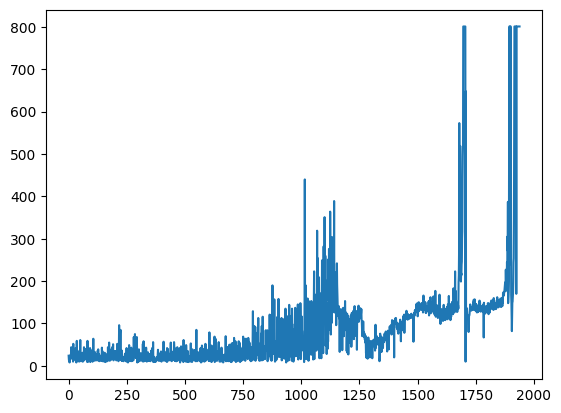

In [99]:
plt.plot(scores)